In [1]:
import numpy as np
import math
from scipy.special import gamma, gammainc, betainc, betaincinv
import matplotlib.pyplot as plt
import scipy as sc
import pandas as pd
from gekko import GEKKO
from scipy.stats import norm
import sympy as sp
import matplotlib

In [2]:
data = pd.read_csv('data/uncertainty_ranges.csv',names = ['year','tech','mu','perc_5','perc_95'], header=0) 
data_electrolysis = pd.read_csv('data/uncertainty_ranges_electrolysis.csv', names = ['year','tech','mu','perc_25','perc_75'], header=0) 
data_other = pd.read_csv('data/uncertainty_ranges_us.csv', names = ['year','tech','mu','perc_20','perc_80'], header=0) 
pred = pd.read_csv("data/Cost_data_summary_V2.csv", names = ["tech", "year", "cost_ratio", "c_inv", "cap", "prod"], header=0)
prosp_data = pd.read_excel("data/prospective_percentiles.xlsx")
hist = pd.read_csv("data/Historical_data_summary.csv", names = ["tech", "year", "c_inv", "cap"], header=0)

# Data handling

In [3]:
pred.replace("HYDRO_TOTAL", "HYDRO", inplace=True)
pred.replace("DEC_SOLAR", "CSP", inplace=True)
hist.replace("HYDRO_TOTAL", "HYDRO", inplace=True)
hist.replace("DEC_SOLAR", "CSP", inplace=True)

In [4]:
prosp_data = prosp_data[prosp_data.year >= 2021]

In [5]:
prosp_data_perc_5 = prosp_data[prosp_data.tech.isin(list(data.tech.unique()))]
prosp_data_perc_5.rename(columns={"c_inv_low":"perc_5", "c_inv_high":"perc_95","c_inv":"mu"}, inplace=True)
prosp_data_perc_5.drop(["cap"], axis=1, inplace=True)
prosp_data_perc_20 = prosp_data[prosp_data.tech.isin(list(data_other.tech.unique()))]
prosp_data_perc_20.rename(columns={"c_inv_low":"perc_20", "c_inv_high":"perc_80","c_inv":"mu"}, inplace=True)
prosp_data_perc_20.drop(["cap"], axis=1, inplace=True)
data_perc_5 = pd.concat([data, prosp_data_perc_5])
data_perc_5.sort_values(["tech", "year"], inplace=True)
data_perc_20 = pd.concat([data_other, prosp_data_perc_20])
data_perc_20.sort_values(["tech", "year"], inplace=True)
data_perc_5.reset_index(inplace=True, drop=True)
data_perc_20.reset_index(inplace=True, drop=True)

C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1676\279058961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prosp_data_perc_5.rename(columns={"c_inv_low":"perc_5", "c_inv_high":"perc_95","c_inv":"mu"}, inplace=True)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1676\279058961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prosp_data_perc_5.drop(["cap"], axis=1, inplace=True)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1676\279058961.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

# PDFs

# Uniform

In [6]:
def cdf_unif(x,a,b):
    if (x<a):
        return 0
    elif (a<=x<=b):
        return ((x-a)/(b-a))
    else:
        return 1

In [7]:
def inv_cdf_unif(p,a,b): # p between 0 and 1
    return a + p*(b-a)

In [8]:
a = 3
b = 10
x = 5
p = cdf_unif(x=x,a=a,b=b)
inv_cdf_unif(p=p,a=a,b=b) == x

True

In [9]:
def pdf_unif(x,a,b):
    if (a <= x <= b):
        return (1/(b-a))
    else:
        return 0

In [10]:
def plot_cdf_unif(x,a,b):
    y = []
    for i in range(len(x)):
        y.append(cdf_unif(x[i],a,b))
    plt.plot(x, y, marker='', linestyle='solid', label="Uniform", color="tab:red")

In [72]:
def plot_pdf_unif(x,a,b):
    y = []
    for i in range(len(x)):
        y.append(pdf_unif(x[i],a,b))
    plt.plot(x, y, marker='', linestyle='solid', label="Uniform", color="tab:red")

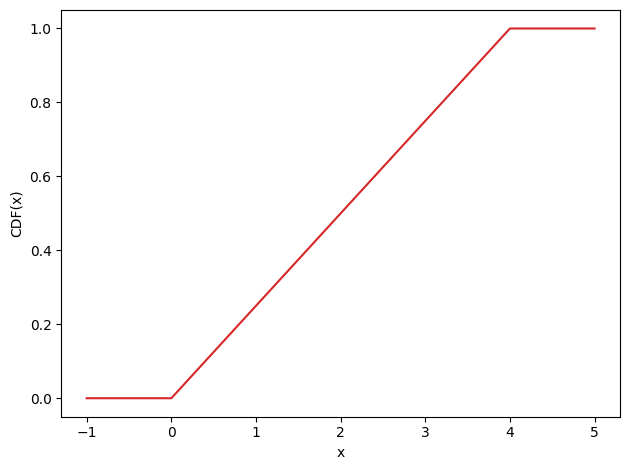

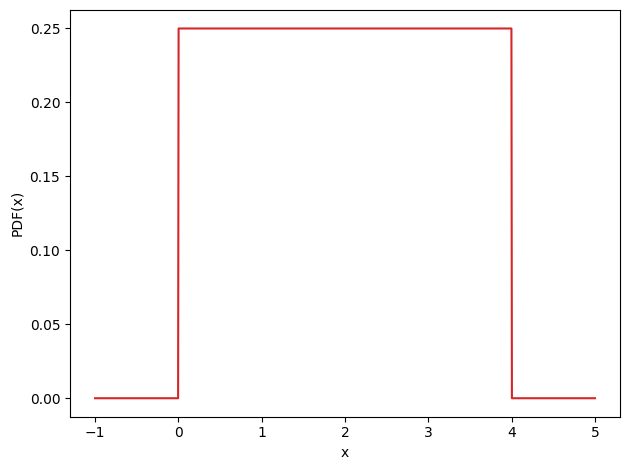

In [12]:
plot_cdf_unif(x=np.linspace(-1, 5, 1000), a=0, b=4)
plt.xticks(range(-1, 6))
plt.xlabel("x")
plt.ylabel("CDF(x)")
plt.tight_layout()
#plt.savefig("pics/example_cdf_Uniform.pdf", format="pdf")
plt.show()
plot_pdf_unif(x=np.linspace(-1, 5, 1000), a=0, b=4, factor=1)
plt.xticks(range(-1, 6))
plt.xlabel("x")
plt.ylabel("PDF(x)")
plt.tight_layout()
#plt.savefig("pics/example_pdf_Uniform.pdf", format="pdf")
plt.show()

## Resolution for uniform 

In [13]:
def system_unif(perc):    
    x1 = sp.symbols("x1")
    x2 = sp.symbols("x2")
    a = sp.symbols("a")
    b = sp.symbols("b")
    equations = [((x1-a) / (b-a)) - perc/100,
                 ((x2-a) / (b-a)) - (1-perc/100)]
    return(sp.solve(equations, [a, b]))

In [14]:
system_unif(perc=5)

{a: 1.05555555555556*x1 - 0.0555555555555556*x2,
 b: -0.0555555555555556*x1 + 1.05555555555556*x2}

In [15]:
system_unif(perc=20)

{a: 1.33333333333333*x1 - 0.333333333333333*x2,
 b: -0.333333333333333*x1 + 1.33333333333333*x2}

In [16]:
data_perc_5["unif_a"] = 1.05555555555556*data_perc_5["perc_5"] - 0.0555555555555556*data_perc_5["perc_95"]
data_perc_5["unif_b"] = -0.0555555555555556*data_perc_5["perc_5"] + 1.05555555555556*data_perc_5["perc_95"]

In [17]:
data_perc_20["unif_a"] = 1.33333333333333*data_perc_20["perc_20"] - 0.333333333333333*data_perc_20["perc_80"]
data_perc_20["unif_b"] = -0.333333333333333*data_perc_20["perc_20"] + 1.33333333333333*data_perc_20["perc_80"]

In [18]:
data_perc_5.head()

,year,tech,mu,perc_5,perc_95,unif_a,unif_b
0,2010,CSP,8830.0,4549.0,12182.0,4124.944444,12606.055556
1,2011,CSP,10403.0,7745.0,17306.0,7213.833333,17837.166667
2,2012,CSP,8040.0,6024.0,12719.0,5652.055556,13090.944444
3,2013,CSP,6307.0,3467.0,9306.0,3142.611111,9630.388889
4,2014,CSP,5414.0,2750.0,7027.0,2512.388889,7264.611111


In [19]:
data_perc_20.head()

,year,tech,mu,perc_20,perc_80,unif_a,unif_b
0,2010,COMMERCIAL_PV,8381.0,7240.0,10164.0,6265.333333,11138.666667
1,2011,COMMERCIAL_PV,4071.0,3511.0,5052.0,2997.333333,5565.666667
2,2012,COMMERCIAL_PV,2837.0,2282.0,3695.0,1811.000000,4166.000000
3,2013,COMMERCIAL_PV,2880.0,2249.0,3898.0,1699.333333,4447.666667
4,2014,COMMERCIAL_PV,2828.0,2232.0,3793.0,1711.666667,4313.333333


# Triangular

In [20]:
def pdf_triang(x,a,b,c):
    if (x < a):
        return 0
    elif (a <= x < c):
        return(2*(x-a) / ((b-a)*(c-a)))
    elif (x==c):
        return(2 / (b-a))
    elif (c < x <= b):
        return(2*(b-x) / ((b-a)*(b-c)))
    else:
        return 0

In [21]:
def cdf_triang(x,a,b,c):
    if (x <= a):
        return 0
    elif (a < x <= c):
        return((x-a)**2 / ((b-a)*(c-a)))
    elif (c < x < b):
        return(1 - (b-x)**2 / ((b-a)*(b-c)))
    else: 
        return 1

In [22]:
def inv_cdf_triang(p,a,b,c): 
    if (0 <= p <= cdf_triang(c,a,b,c)):
        return a + np.sqrt((b-a)*(c-a)*p)
    elif (cdf_triang(c,a,b,c) < p <= 1):
        return b - np.sqrt((b-a)*(b-c)*(1-p))

In [23]:
a = 3
c = 7
b = 10
x = 5
p = cdf_triang(x=x,a=a,b=b,c=c)
inv_cdf_triang(p=p,a=a,b=b,c=c) == x

True

In [24]:
def mean_triang(a,b,c):
    return((a+b+c)/3)

In [25]:
def mode_triang(a,b,c):
    return(c)

# 3-parameters Weibull

In [26]:
def cdf_weibull(x,a,b,c):
    if (x >= c):
        return 1 - np.exp(-((x-c)/a)**b)
    else:
        return 0

In [27]:
def pdf_weibull(x,a,b,c):
    if (x >= c):
        return (b/a)*(((x-c)/a)**(b-1))*np.exp(-((x-c)/a)**b)
    else:
        return 0

In [28]:
def mean_weibull(a,b,c):
    return c + a*gamma(1+1/b)

In [29]:
def mode_weibull(a,b,c):
    if (b >= 1):
        return a*((b-1)/b)**(1/b) + c
    else:
        return 0

# PERT 

In [30]:
def B(a,b):
    return(gamma(a)*gamma(b)/gamma(a+b))

In [31]:
def pdf_pert(x,a,b,c): # a < b < c, a:min, b:max
    if (a <= x <= b):
        alpha = 1 + 4*(c-a)/(b-a)
        beta = 1 + 4*(b-c)/(b-a)
        return((x-a)**(alpha-1) * (b-x)**(beta-1) / (B(alpha, beta)*(b-a)**(alpha+beta-1)))
    else:
        return 0

In [32]:
def cdf_pert(x,a,b,c):
    if (a <= x <= b):
        alpha = 1 + 4*(c-a)/(b-a)
        beta = 1 + 4*(b-c)/(b-a)
        z = (x-a)/(b-a)
        return betainc(alpha, beta, z)
    elif (x < a):
        return 0
    else:
        return 1

In [33]:
def inv_cdf_pert(p,a,b,c):
    alpha = 1 + 4*(c-a)/(b-a)
    beta = 1 + 4*(b-c)/(b-a)
    z = betaincinv(alpha, beta, p)
    return z*(b-a) + a

In [34]:
a = 3
c = 7
b = 10
x = 5
p = cdf_pert(x=x,a=a,b=b,c=c)
inv_cdf_pert(p=p,a=a,b=b,c=c) == x

True

In [35]:
def mean_pert(a,b,c):
    return (a+b+4*c)/6

In [36]:
def mode_pert(a,b,c):
    return(c)

# Generalized gamma

In [37]:
def pdf_gamma(x,a,b,c):
    if (x > 0):
        return (c/(a**b))*x**(b-1)*np.exp(-(x/a)**c)/gamma(b/c)
    else:
        return 0

In [38]:
def cdf_gamma(x,a,b,c):
    if (x > 0):
        return gammainc(b/c,(x/a)**c)
    else: 
        return 0

In [39]:
def mean_gamma(a,b,c):
    return a*gamma((b+1)/c)/gamma(b/c)

In [40]:
def mode_gamma(a,b,c):
    if (b > 1):
        return a*((b-1)/c)**(1/c)
    else:
        return 0

# Generalized Kumaraswamy distribution

In [41]:
def cdf_kumaraswamy(x,a,b,c,d=0):
    if (x <= d):
        return 0
    elif (x >= c):
        return 1
    else:
        return(1 - (1 - ((x-d) / (c-d))**a)**b)

In [42]:
def pdf_kumaraswamy(x,a,b,c,d=0):
    if (x <= d):
        return 0
    elif (x >= c):
        return 0
    else:
        return(a*b*((x-d)/(c-d))**(a-1)*(1-((x-d)/(c-d))**a)**(b-1))

In [43]:
def mode_kumaraswamy(a,b,c,d=0):
    return((c-d)*((a-1)/(a*b-1))**(1/a))

# Shifted log-logistic distribution

In [44]:
def cdf_shifted_log(x, a, b, c): # a:mu, b:sigma, c:eps
    if ((c > 0) & (x < a - b/c)):
        return 0 
    elif ((c < 0) & (x > a - b/c)):
        return 1
    else:
        z = (x-a) / b
        return (1 + (1 + c*z)**(-1/c))**(-1)

In [45]:
def inv_cdf_shifted_log(p,a,b,c):
    return a + (b/c) * ((1/p - 1)**(-c) - 1)

In [46]:
a = 1
c = 0.5
b = 0.5
x = 4
p = cdf_shifted_log(x=x,a=a,b=b,c=c)
inv_cdf_shifted_log(p=p,a=a,b=b,c=c) == x

True

In [47]:
def pdf_shifted_log(x, a, b, c):
    if ((c > 0) & (x < a - b/c)):
        return 0 
    elif ((c < 0) & (x > a - b/c)):
        return 0
    else:
        z = (x-a) / b
        return((1+c*z)**(-1/c-1)/(b*(1 + (1+c*z)**(-1/c))**2))

In [48]:
def mode_shifted_log(a, b, c):
    return(a + (b/c)*(((1-c)/(1+c))**(c) - 1))

# PDF fitting

## Least squares on CDFs via curve_fit

In [49]:
def least_squares(func, x0, x1, x2, perc):
    
    if (func == cdf_pert):
        init_guess = [x0, x1, x2]
    elif (func == cdf_weibull):
        init_guess = [3000, 0, 0]
    elif (func == cdf_gamma):
        initial_guess = [x1, 5, 3]
    
    condition = False 
    
    while (condition == False):
        xm = np.array([x0, x1, x2])
        ym = np.array([perc, 1.0-perc, 0.50])

        popt, pcov = sc.optimize.curve_fit(func, xm, ym, p0 = init_guess, maxfev = 100000)
        
        condition = ((round(func(x=x0,a=popt[0],b=popt[1],c=popt[2]) - perc, 2) == 0) 
                     & (round(func(x=x1,a=popt[0],b=popt[1],c=popt[2]) - (1.0-perc), 2) == 0)
                     & (round(func(x=x2,a=popt[0],b=popt[1],c=popt[2]) - 0.50, 2) == 0))
        #print(x0, popt, perc)
        #print(cdf_pert(x=x0,a=popt[0],b=popt[1],c=popt[2]) - perc)
        
        if (func == cdf_pert):
            init_guess[0] = np.random.randint(0, x1)
            init_guess[2] = np.random.randint(x2, x2+200)
        elif (func == cdf_weibull):
            init_guess[0] = np.random.randint(0, 3000)
            init_guess[1] = np.random.randint(0, 5)
            init_guess[2] = np.random.randint(-100, 100)
        elif (func == cdf_gamma):
            init_guess[1] = np.random.randint(1, 10)
            init_guess[2] = np.random.randint(1, 5)
    
    return(popt)

In [50]:
def results(df, func, percentile):
    a = []
    b = []
    c = []
    for i in range(df.shape[0]):
        
        if (float(df.loc[[i],:]["perc_"+str(percentile)]) == float(df.loc[[i],:].mu) == float(df.loc[[i],:]["perc_"+str(100-percentile)])):
            a.append(float(df.loc[[i],:]["perc_"+str(percentile)].to_numpy()))
            b.append(float(df.loc[[i],:]["perc_"+str(100-percentile)].to_numpy()))
            c.append(float(df.loc[[i],:].mu.to_numpy()))

        else:
            #print(i,float(df.loc[[i],:].perc_05) , float(df.loc[[i],:].mu) , float(df.loc[[i],:].perc_95))
            root = least_squares(x0=float(df.loc[[i],:]["perc_"+str(percentile)]), 
                                 x1=float(df.loc[[i],:]["perc_"+str(100-percentile)]), 
                                 x2=float(df.loc[[i],:].mu),
                                 perc=percentile/100,
                                 func=func)
            
            a.append(root[0])
            b.append(root[1])
            c.append(root[2])
    
    return(a, b, c)

## Solving a non-linear system of equations

In [51]:
function_mappings = {"Triangular":{"cdf":cdf_triang, "pdf":pdf_triang, "mean":mean_triang, "mode":mode_triang}, 
                     "Weibull":{"cdf":cdf_weibull, "pdf":pdf_weibull, "mean":mean_weibull, "mode":mode_weibull}, 
                     "PERT":{"cdf":cdf_pert, "pdf":pdf_pert, "mean":mean_pert, "mode":mode_pert}, 
                     "Gamma":{"cdf":cdf_gamma, "pdf":pdf_gamma, "mean":mean_gamma, "mode":mode_gamma}, 
                     "Kumaraswamy":{"cdf":cdf_kumaraswamy, "pdf":pdf_kumaraswamy, "mode":mode_kumaraswamy}, 
                     "Shifted log-logistic":{"cdf":cdf_shifted_log, "pdf":pdf_shifted_log, "mode":mode_shifted_log}}

In [52]:
pdf_list = ["Triangular", "PERT", "Shifted log-logistic"]

In [53]:
def system_with_param(y, x0, x1, x2, perc, func):
    return([function_mappings[func]["cdf"](x=x0,a=y[0],b=y[1],c=y[2]) - perc/100,
            function_mappings[func]["cdf"](x=x1,a=y[0],b=y[1],c=y[2]) - (1-perc/100), 
            #function_mappings[func]["mean"](a=y[0],b=y[1],c=y[2])/x2 - 1]) # 3rd equation about distribution mean value
            function_mappings[func]["mode"](a=y[0],b=y[1],c=y[2])/x2 - 1]) # 3rd equation about the distribution mode (most likely) value
            #function_mappings[func]["cdf"](x=x2,a=y[0],b=y[1],c=y[2]) - (50/100)]) # 3rd equation about distribution median value

In [54]:
def solving(df, perc, func):
    
    N = df.shape[0]
    
    a = []
    b = []
    c = []
    
    for i in range(N):
        
        eps = [0.001, 0.001, 0.01]
        
        x0 = float(df.loc[[i],:]["perc_"+str(perc)])
        x1 = float(df.loc[[i],:]["perc_"+str(100-perc)])
        x2 = float(df.loc[[i],:].mu)
        
        if (x0 == x1 == x2):
            a.append(x0)
            b.append(x1)
            c.append(x2)

        else:
            
            def system(y):
                return(system_with_param(y, x0=x0, x1=x1, x2=x2, perc=perc, func=func))
            
            if ((func == "Triangular") | (func == "PERT")):
                init_guess = [x0-200, x1+200, x2]
                method = "lm"
            elif (func == "Weibull"):
                init_guess = [3000, 0, 0]
                method = "lm"
            elif (func == "Gamma"):
                init_guess = [x1, 5, 3]
                method = "lm"
            elif (func == "Kumaraswamy"):
                method = "lm"
                init_guess = [5, 10, x1+200]
            elif (func == "Shifted log-logistic"):
                method = "lm"
                init_guess = [x2, 500, 0]
            
            condition = False
            counter = 0
            
            while (condition == False):
            
                #sol = sc.optimize.fsolve(func=system, x0=[800, 6500, 2500], xtol=1e-6, maxfev=10000)
                sol = sc.optimize.root(fun=system, x0=init_guess, tol=1e-6, method=method, options={"maxiter":100000, "xtol":1e-6})
                #if (sol.success == False):
                #    return(func, "cannot converge for row", i)
                condition = ((np.abs(sol.fun[0]) <= eps[0]) 
                             & (np.abs(sol.fun[1]) <= eps[1]) 
                             & (np.abs(sol.fun[2]) <= eps[2]))
                
                if (condition == False):
                    if ((func == "Triangular") | (func == "PERT")):
                        d = np.random.uniform(0, 200)
                        init_guess = [x0-d, x1+d, x2]
                    elif (func == "Weibull"):
                        init_guess = [np.random.uniform(10, 3000), np.random.uniform(0.1, 10), np.random.uniform(-10, 1000)]
                    elif (func == "Gamma"):
                        init_guess = [np.random.uniform(0.001, 100*x2), np.random.uniform(0.1, 30), np.random.uniform(0.1, 10)]  
                    elif (func == "Kumaraswamy"):
                        init_guess = [np.random.uniform(0.1, 3), np.random.uniform(0.1, 3), np.random.uniform(x2, x2+500)]
                    elif (func == "Shifted log-logistic"):
                        init_guess = [np.random.uniform(x2-200, x2+200), np.random.uniform(100, 1000), np.random.uniform(-10, 10)]
                
                counter+=1
                
                if (counter == 100):
                    eps = [0.01, 0.01, 0.05]
                #elif (counter == 10000):
                #    eps = 0.03
                
                #print(x0, x1, x2, init_guess, sol.fun)
                
            a.append(sol.x[0])
            b.append(sol.x[1])
            c.append(sol.x[2])
            print(sol.x)
        print(func, i, "over", df.shape[0]-1)
    
    return(a, b, c)

In [55]:
data_perc_20_2050 = data_perc_20[data_perc_20.year == 2050]
data_perc_20_2050.reset_index(inplace=True, drop=True)
data_perc_5_2050 = data_perc_5[data_perc_5.year == 2050]
data_perc_5_2050.reset_index(inplace=True, drop=True)

In [56]:
data_perc_20_2050

,year,tech,mu,perc_20,perc_80,unif_a,unif_b
0,2050,COMMERCIAL_PV,810.26,749.789378,1444.408981,518.249510,1675.948848
1,2050,RES_PV,654.50,569.695247,1998.119863,93.553708,2474.261401


In [57]:
data_perc_5_2050

,year,tech,mu,perc_5,perc_95,unif_a,unif_b
0,2050,CSP,2367.910,889.596940,2432.986636,803.853068,2518.730508
1,2050,GEOTHERMAL,6682.740,4395.537884,8229.099964,4182.562213,8442.075635
2,2050,HYDRO,3663.010,2762.057299,20737.263886,1763.434711,21735.886474
3,2050,OFFSHORE_WIND,1647.694,1391.374202,4207.361184,1234.930481,4363.804905
4,2050,ONSHORE_WIND,838.070,380.909139,1444.336419,321.829846,1503.415712
5,2050,UTILITY_PV,371.480,202.502347,2002.685425,102.492176,2102.695596


In [58]:
solving(df=data_perc_5_2050, perc=5, func="Shifted log-logistic")

[ 2.21593667e+03  1.59535631e+02 -6.14735356e-01]
Shifted log-logistic 0 over 5
[ 6.56670516e+03  6.43312312e+02 -9.06813586e-02]
Shifted log-logistic 1 over 5
[5.46176905e+03 1.93018944e+03 5.88602754e-01]
Shifted log-logistic 2 over 5
[1.93546729e+03 3.47274454e+02 4.85406129e-01]
Shifted log-logistic 3 over 5
[8.61511446e+02 1.79467858e+02 6.54952610e-02]
Shifted log-logistic 4 over 5
[5.55246465e+02 2.23635160e+02 4.79482894e-01]
Shifted log-logistic 5 over 5


C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1676\2187731958.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  if ((c > 0) & (x < a - b/c)):
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1676\2187731958.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  elif ((c < 0) & (x > a - b/c)):
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1676\2187731958.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 + (1 + c*z)**(-1/c))**(-1)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1676\2290802768.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return(a + (b/c)*(((1-c)/(1+c))**(c) - 1))
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1676\2187731958.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  if ((c > 0) & (x < a - b/c)):
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1676\2187731958.py:4: RuntimeWarning: divide by zero encountered in double

([2215.936667692841,
  6566.705164682032,
  5461.769047106987,
  1935.4672909252456,
  861.5114460374673,
  555.2464654360759],
 [159.53563098449484,
  643.31231159415,
  1930.1894436608457,
  347.2744537086992,
  179.46785754926927,
  223.63516040412833],
 [-0.6147353564824244,
  -0.09068135859972225,
  0.5886027541624512,
  0.4854061287241466,
  0.06549526098668958,
  0.47948289360621665])

In [59]:
def adding_results(df, perc):
    for pdf in pdf_list:    
        (a,b,c) = solving(df=df, perc=perc, func=pdf)
        df[pdf+"_a"] = pd.Series(a)
        df[pdf+"_b"] = pd.Series(b)
        df[pdf+"_c"] = pd.Series(c)

In [60]:
adding_results(df=data_perc_5_2050, perc=5)
adding_results(df=data_perc_20_2050, perc=20)

[ 433.21989954 2586.32961851 2367.91      ]
Triangular 0 over 5
[3443.28118696 9041.70283881 6682.74      ]
Triangular 1 over 5
[  897.40765381 26041.42957     3663.01      ]
Triangular 2 over 5
[1044.9015073  5027.80872469 1647.694     ]
Triangular 3 over 5
[ 149.61975246 1703.6835491   838.07      ]
Triangular 4 over 5
[ -21.13979461 2526.65877286  371.48      ]
Triangular 5 over 5
[-803.8192107  2486.11763064 2367.91      ]
PERT 0 over 5
[2757.21057789 9027.17547204 6682.74      ]
PERT 1 over 5
[ 2113.7590578 40141.1990271  3663.01     ]
PERT 2 over 5
[1263.03333616 6995.77690335 1647.694     ]
PERT 3 over 5
[ 134.1441692 1860.1319965  838.07     ]
PERT 4 over 5
[ 119.13912964 3774.27717364  371.48      ]
PERT 5 over 5
[ 2.21593667e+03  1.59535631e+02 -6.14735356e-01]
Shifted log-logistic 0 over 5
[ 6.56670516e+03  6.43312312e+02 -9.06813586e-02]
Shifted log-logistic 1 over 5
[5.46176905e+03 1.93018944e+03 5.88602754e-01]
Shifted log-logistic 2 over 5
[1.93546729e+03 3.47274454e+02 

C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1676\4255686652.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pdf+"_a"] = pd.Series(a)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1676\4255686652.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pdf+"_b"] = pd.Series(b)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_1676\4255686652.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [61]:
data_perc_5_2050.isnull().sum()

year                      0
tech                      0
mu                        0
perc_5                    0
perc_95                   0
unif_a                    0
unif_b                    0
Triangular_a              0
Triangular_b              0
Triangular_c              0
PERT_a                    0
PERT_b                    0
PERT_c                    0
Shifted log-logistic_a    0
Shifted log-logistic_b    0
Shifted log-logistic_c    0
dtype: int64

In [62]:
data_perc_20_2050.isnull().sum()

year                      0
tech                      0
mu                        0
perc_20                   0
perc_80                   0
unif_a                    0
unif_b                    0
Triangular_a              0
Triangular_b              0
Triangular_c              0
PERT_a                    0
PERT_b                    0
PERT_c                    0
Shifted log-logistic_a    0
Shifted log-logistic_b    0
Shifted log-logistic_c    0
dtype: int64

# Solving for triangular especially

In [42]:
(a,b,c) = solving(df=data_perc_5, perc=5, func="Triangular")
data_perc_5["triang_a"] = pd.Series(a)
data_perc_5["triang_b"] = pd.Series(b)
data_perc_5["triang_c"] = pd.Series(c)

[ 2699.76420258 13856.50644696  8830.        ]
Triangular 0 over 267
[ 5996.87829125 19868.16787701 10403.        ]
Triangular 1 over 267
[ 4761.01604566 14490.42302736  8040.        ]
Triangular 2 over 267
[ 2131.85604208 10671.00777591  6307.        ]
Triangular 3 over 267
[1669.02931254 7909.38591163 5414.        ]
Triangular 4 over 267
[2233.73870826 9757.78525356 7232.        ]
Triangular 5 over 267
[ 1038.07035847 12898.19556699  7602.        ]
Triangular 6 over 267
[2568.01546779 9670.39158591 7196.        ]
Triangular 7 over 267
[2596.92308449 7502.94591177 5161.        ]
Triangular 8 over 267
[2494.72697952 9474.71429137 6466.        ]
Triangular 9 over 267
[4068.04004727 5158.91648523 4448.        ]
Triangular 10 over 267
[ 817.15541947 7444.21304548 5441.7       ]
Triangular 11 over 267
[ 381.34046461 6615.45945235 4933.65      ]
Triangular 12 over 267
[ 181.62339402 6078.37991124 4603.24      ]
Triangular 13 over 267
[  88.18488955 5689.23664558 4362.67      ]
Triangular 14

[2029.43442621 7435.61243118 5233.        ]
Triangular 136 over 267
[2307.66386428 6398.1981671  4631.        ]
Triangular 137 over 267
[1110.5761824  6359.05201876 4894.        ]
Triangular 138 over 267
[1082.76275369 7150.45926797 5153.        ]
Triangular 139 over 267
[2125.05594243 6962.92342861 5168.        ]
Triangular 140 over 267
[2284.2629698  4764.78480829 3981.        ]
Triangular 141 over 267
[2024.14791207 5889.38870549 4573.        ]
Triangular 142 over 267
[1229.00189546 6137.22537767 4493.        ]
Triangular 143 over 267
[2338.65797739 6630.40529556 3615.        ]
Triangular 144 over 267
[2182.35130129 6222.14616199 3092.        ]
Triangular 145 over 267
[1889.48367528 5825.40567525 3477.891     ]
Triangular 146 over 267
[1899.43399986 5707.66991535 3241.314     ]
Triangular 147 over 267
[1909.57078926 5622.92448775 3071.768     ]
Triangular 148 over 267
[1919.70152947 5556.40406705 2939.54      ]
Triangular 149 over 267
[1929.83358183 5501.47800432 2831.129     ]
Tria

[ -16.28050762 2527.95350764  381.91      ]
Triangular 264 over 267
[ -17.95918551 2527.49241324  378.31      ]
Triangular 265 over 267
[ -19.57942007 2527.06123482  374.84      ]
Triangular 266 over 267
[ -21.13979461 2526.65877286  371.48      ]
Triangular 267 over 267


In [44]:
(a,b,c) = solving(df=data_perc_20, perc=20, func="Triangular")
data_perc_20["triang_a"] = pd.Series(a)
data_perc_20["triang_b"] = pd.Series(b)
data_perc_20["triang_c"] = pd.Series(c)

[ 4885.11413326 12816.56220789  8381.        ]
Triangular 0 over 78
[2292.76131433 6465.72613402 4071.        ]
Triangular 1 over 78
[1142.0621597  4975.41300258 2837.        ]
Triangular 2 over 78
[ 927.74659385 5398.76085296 2880.        ]
Triangular 3 over 78
[ 981.9829687  5214.18275898 2828.        ]
Triangular 4 over 78
[ 746.87667335 3763.86172878 2221.        ]
Triangular 5 over 78
[ 587.97800445 3559.43212087 1821.        ]
Triangular 6 over 78
[ 677.97930891 3952.42158696 2100.        ]
Triangular 7 over 78
[ 491.77395482 3710.7522285  1963.        ]
Triangular 8 over 78
[ 473.72664952 3019.77640157 1648.        ]
Triangular 9 over 78
[ 358.85657643 2515.28681936 1309.        ]
Triangular 10 over 78
[ 280.55224507 2524.93568493 1317.43      ]
Triangular 11 over 78
[ 268.86833381 2405.30758548 1199.        ]
Triangular 12 over 78
[ 267.47175859 2339.55477573 1125.58      ]
Triangular 13 over 78
[ 269.50865955 2297.77956534 1074.61      ]
Triangular 14 over 78
[ 272.80923341 22

## Output triangular parameters

In [57]:
results_triang_prosp = pd.concat([data_perc_5[["year", "tech", "triang_a", "triang_b", "triang_c"]],
                                  data_perc_20[["year", "tech", "triang_a", "triang_b", "triang_c"]]])

In [88]:
pred = pred[pred.year >= 2021]

In [89]:
cap_data = pd.concat([hist, pred])

In [90]:
results_triang_prosp = pd.merge(results_triang_prosp, cap_data[["tech", "year", "cap"]], on=["tech", "year"], how="inner")

In [91]:
def hist_or_prosp(year):
    if (year <= 2020):
        return("Historical")
    else:
        return("Prospective")

In [92]:
results_triang_prosp["Historical or prospective"] = results_triang_prosp.apply(lambda x: hist_or_prosp(x.year), axis=1)

In [93]:
results_triang_prosp

,year,tech,triang_a,triang_b,triang_c,cap_x,Historical or prospective,cap_y
0,2010,CSP,2699.764203,13856.506447,8830.00,1.266,Historical,1.266
1,2011,CSP,5996.878291,19868.167877,10403.00,1.705,Historical,1.705
2,2012,CSP,4761.016046,14490.423027,8040.00,2.567,Historical,2.567
3,2013,CSP,2131.856042,10671.007776,6307.00,3.842,Historical,3.842
4,2014,CSP,1669.029313,7909.385912,5414.00,4.499,Historical,4.499
...,...,...,...,...,...,...,...,...
343,2046,RES_PV,-213.353982,3414.572077,682.24,1765.820,Prospective,1765.820
344,2047,RES_PV,-220.146204,3416.308955,674.93,1812.820,Prospective,1812.820
345,2048,RES_PV,-226.704118,3418.021792,667.88,1859.820,Prospective,1859.820
346,2049,RES_PV,-233.036828,3419.710928,661.07,1906.820,Prospective,1906.820


In [94]:
#results_triang_prosp.to_excel("results_with_CI.xlsx", index=False)

## Output 5th and 95th percentiles

In [95]:
data_perc_20["perc_5"] = data_perc_20.apply(lambda x: inv_cdf_triang(p=0.05,a=x.triang_a,b=x.triang_b,c=x.triang_c), axis=1)

In [96]:
data_perc_20["perc_95"] = data_perc_20.apply(lambda x: inv_cdf_triang(p=0.95,a=x.triang_a,b=x.triang_b,c=x.triang_c), axis=1)

In [97]:
results_percentiles = pd.concat([data_perc_20[["year", "tech", "mu", "perc_5", "perc_95"]], 
                                 data_perc_5[["year", "tech", "mu", "perc_5", "perc_95"]]])

In [98]:
results_percentiles = pd.merge(results_percentiles, cap_data[["tech", "year", "cap"]], on=["tech", "year"], how="inner")

In [99]:
results_percentiles["Historical or prospective"] = results_percentiles.apply(lambda x: hist_or_prosp(x.year), axis=1)

In [100]:
results_percentiles

,year,tech,mu,perc_5,perc_95,cap,Historical or prospective
0,2010,COMMERCIAL_PV,8381.00,6062.557067,11490.281104,21.00,Historical
1,2011,COMMERCIAL_PV,4071.00,2901.880657,5758.863067,35.00,Historical
2,2012,COMMERCIAL_PV,2837.00,1712.031080,4335.206501,47.00,Historical
3,2013,COMMERCIAL_PV,2880.00,1588.373297,4648.380426,57.00,Historical
4,2014,COMMERCIAL_PV,2828.00,1606.991484,4503.591379,67.00,Historical
...,...,...,...,...,...,...,...
319,2046,UTILITY_PV,385.64,211.034143,2006.474395,7243.26,Prospective
320,2047,UTILITY_PV,381.91,208.785020,2005.457723,7436.05,Prospective
321,2048,UTILITY_PV,378.31,206.616418,2004.489554,7628.85,Prospective
322,2049,UTILITY_PV,374.84,204.523740,2003.566531,7821.64,Prospective


In [101]:
#results_percentiles.to_excel("results_percentiles.xlsx", index=False)

# Visualisation of the PDFs

In [85]:
font = {'family' : 'Arial',
        'size'   : 28}

matplotlib.rc('font', **font)
plt.rcParams.update({'mathtext.default':'regular'})

In [64]:
def plot_cdf(func,x,a,b,c):
    y = []
    for i in range(len(x)):
        y.append(function_mappings[func]["cdf"](x[i],a,b,c))
    plt.plot(x, y, marker='', linestyle='solid', label=func)

In [71]:
def plot_pdf(func,x,a,b,c):
    y = []
    for i in range(len(x)):
        y.append(function_mappings[func]["pdf"](x[i],a,b,c))
    plt.plot(x, y, marker='', linestyle='solid', label=func)

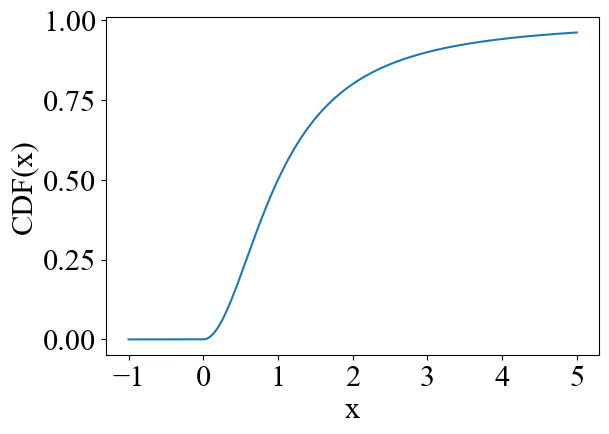

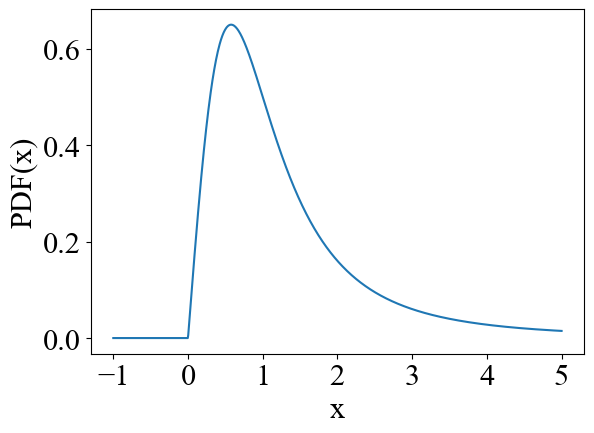

In [66]:
func = "Shifted log-logistic"
a = 1
b = 0.5
c = 0.5
plot_cdf(func, np.linspace(-1, 5, 1000), a, b, c)
plt.xticks(range(-1, 6))
plt.xlabel("x")
plt.ylabel("CDF(x)")
plt.tight_layout()
#plt.savefig("pics/example_cdf_"+func+".pdf", format="pdf")
plt.show()
plt.figure()
plot_pdf(func, np.linspace(-1, 5, 1000), a, b, c, factor=1)
plt.xticks(range(-1, 6))
plt.xlabel("x")
plt.ylabel("PDF(x)")
plt.tight_layout()
#plt.savefig("pics/example_pdf_"+func+".pdf", format="pdf")
plt.show()
#mode = mode_kumaraswamy(a,b,c,d)
#plt.axvline(mode, linestyle='dashed',label="Mode")

In [67]:
data_perc_5_2050

,year,tech,mu,perc_5,perc_95,unif_a,unif_b,Triangular_a,Triangular_b,Triangular_c,PERT_a,PERT_b,PERT_c,Shifted log-logistic_a,Shifted log-logistic_b,Shifted log-logistic_c
0,2050,CSP,2367.910,889.596940,2432.986636,803.853068,2518.730508,433.219900,2586.329619,2367.910,-803.819211,2486.117631,2367.910,2215.936668,159.535631,-0.614735
1,2050,GEOTHERMAL,6682.740,4395.537884,8229.099964,4182.562213,8442.075635,3443.281187,9041.702839,6682.740,2757.210578,9027.175472,6682.740,6566.705165,643.312312,-0.090681
2,2050,HYDRO,3663.010,2762.057299,20737.263886,1763.434711,21735.886474,897.407654,26041.429570,3663.010,2113.759058,40141.199027,3663.010,5461.769047,1930.189444,0.588603
3,2050,OFFSHORE_WIND,1647.694,1391.374202,4207.361184,1234.930481,4363.804905,1044.901507,5027.808725,1647.694,1263.033336,6995.776903,1647.694,1935.467291,347.274454,0.485406
4,2050,ONSHORE_WIND,838.070,380.909139,1444.336419,321.829846,1503.415712,149.619752,1703.683549,838.070,134.144169,1860.131996,838.070,861.511446,179.467858,0.065495
5,2050,UTILITY_PV,371.480,202.502347,2002.685425,102.492176,2102.695596,-21.139795,2526.658773,371.480,119.139130,3774.277174,371.480,555.246465,223.635160,0.479483


In [82]:
data_perc_20_2050

,year,tech,mu,perc_20,perc_80,unif_a,unif_b,Triangular_a,Triangular_b,Triangular_c,PERT_a,PERT_b,PERT_c,Shifted log-logistic_a,Shifted log-logistic_b,Shifted log-logistic_c
0,2050,COMMERCIAL_PV,810.26,749.789378,1444.408981,518.249510,1675.948848,337.824157,2133.997601,810.26,504.961583,2919.526376,810.26,993.424784,235.372561,0.444177
1,2050,RES_PV,654.50,569.695247,1998.119863,93.553708,2474.261401,-239.171145,3421.374704,654.50,97.968141,5168.458689,654.50,1051.547263,478.034797,0.487062


CSP


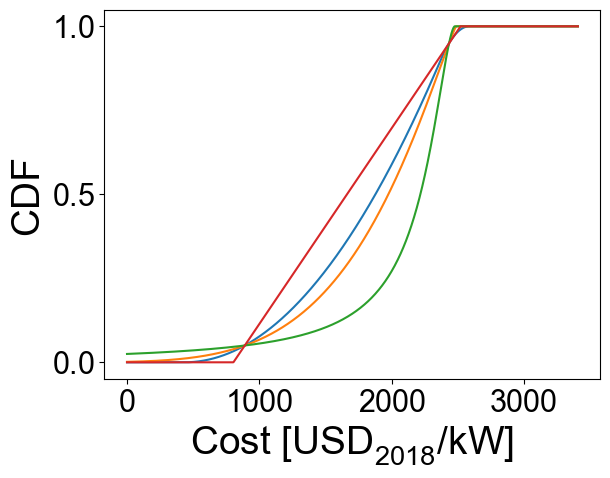

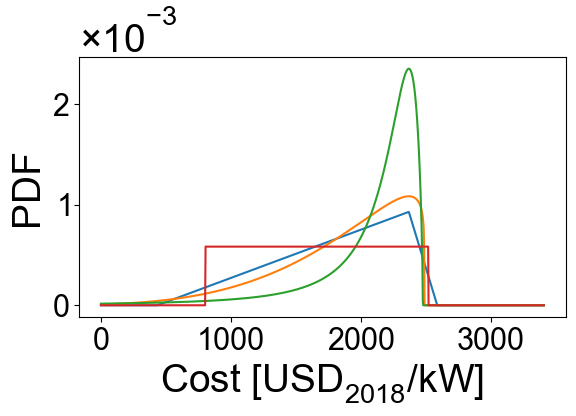

GEOTHERMAL


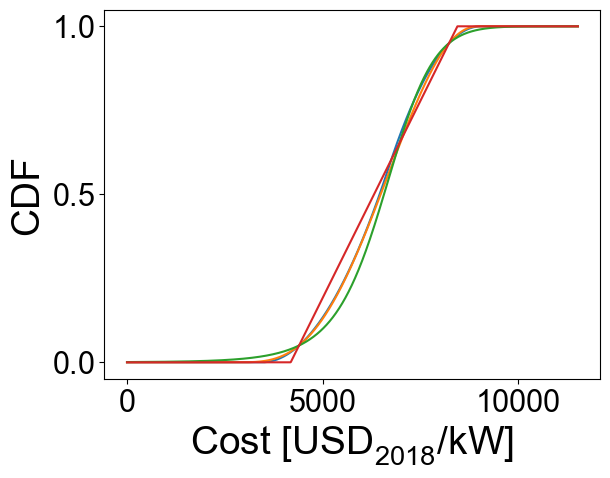

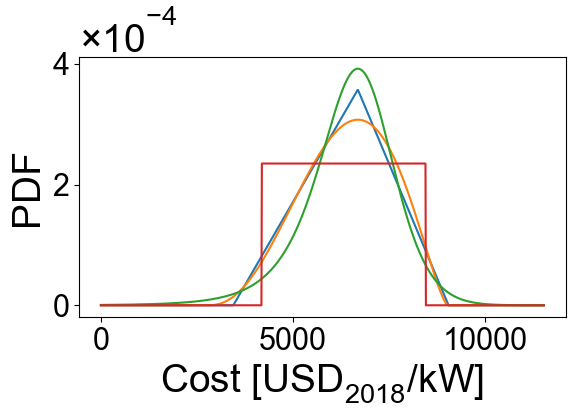

HYDRO


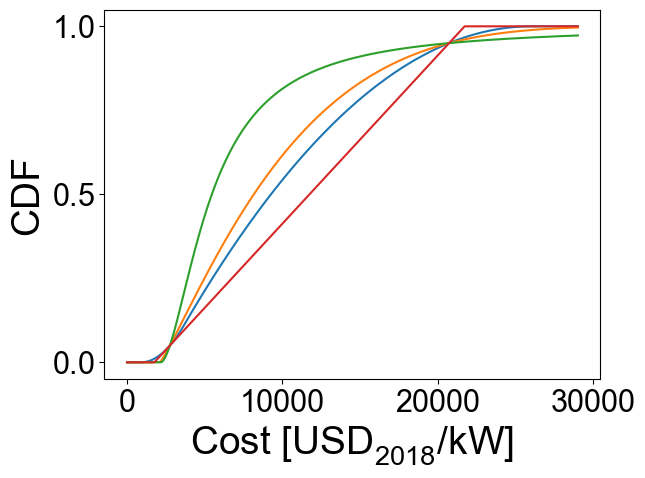

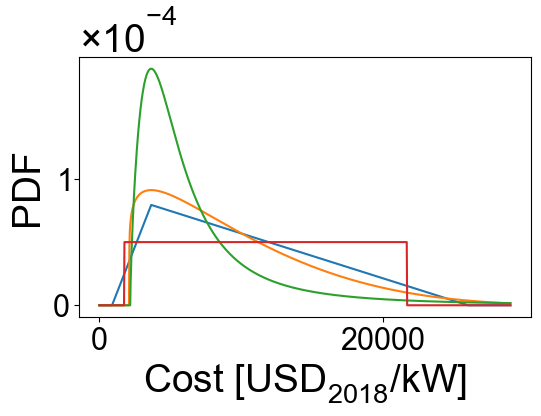

OFFSHORE_WIND


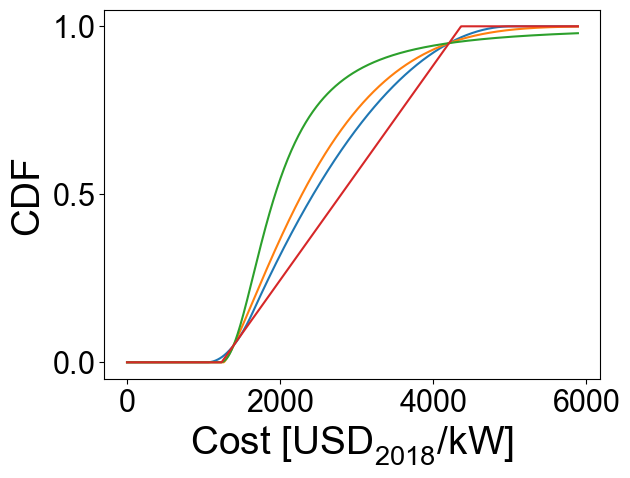

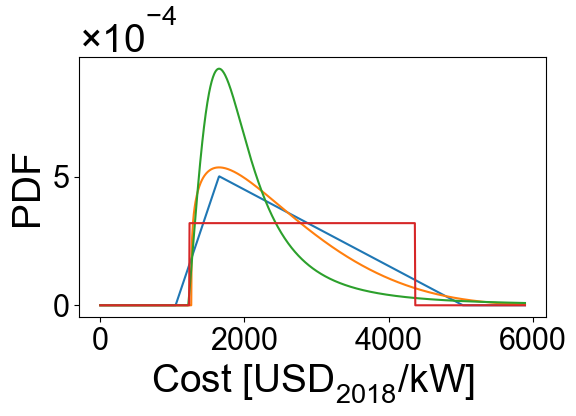

ONSHORE_WIND


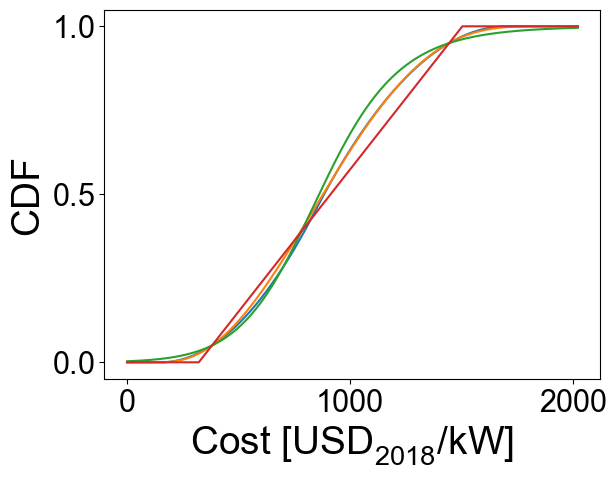

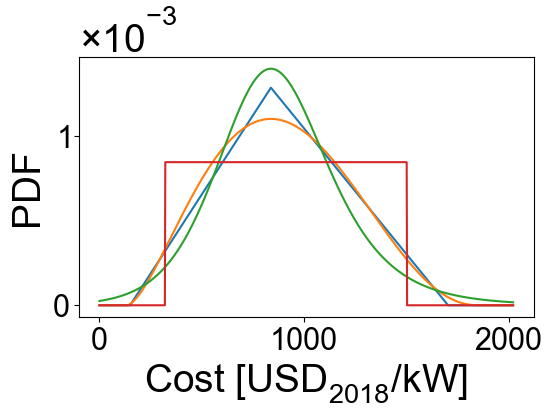

UTILITY_PV


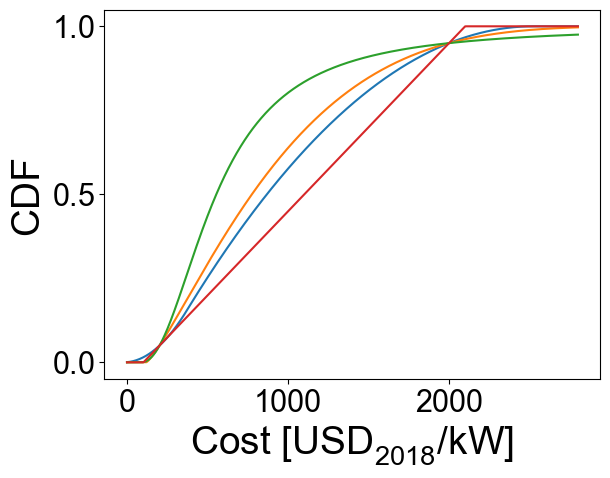

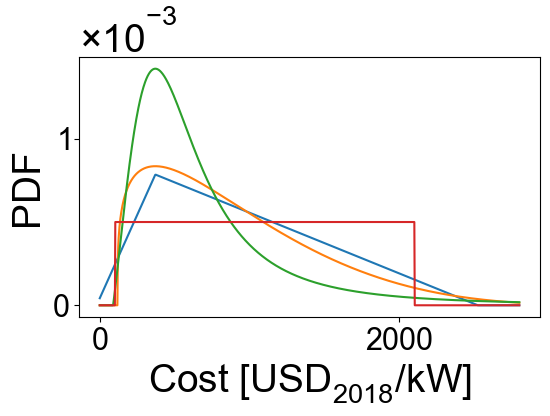

In [88]:
for i in range(data_perc_5_2050.shape[0]):
    data_plot = data_perc_5_2050.iloc[i]
    print(data_plot.tech)
    #print(data_plot)
    x = np.linspace(0, 1.40*data_plot.perc_95, 1000)

    #plt.axvline(float(data_plot.perc_5), linestyle='dashed',label="5th percentile")
    #plt.axvline(float(data_plot.perc_95), linestyle='dotted',label="95th percentile")
    for pdf in pdf_list:
        plot_cdf(func=pdf,x=x,a=float(data_plot[pdf+"_a"]),b=float(data_plot[pdf+"_b"]),c=float(data_plot[pdf+"_c"]))
    plot_cdf_unif(x=x,a=float(data_plot["unif_a"]),b=float(data_plot["unif_b"]))
    #plt.legend(fontsize=15)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
    plt.xlabel("Cost [USD$_{2018}$/kW]")
    plt.ylabel("CDF")
    plt.show()

    #plt.axvline(float(data_plot.mu), linestyle='dashed',label="Mode")
    for pdf in pdf_list:
        plot_pdf(func=pdf,x=x,a=float(data_plot[pdf+"_a"]),b=float(data_plot[pdf+"_b"]),c=float(data_plot[pdf+"_c"]))
    plot_pdf_unif(x=x,a=float(data_plot["unif_a"]),b=float(data_plot["unif_b"]))

    #plt.legend(fontsize=15)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
    plt.xlabel("Cost [USD$_{2018}$/kW]")
    plt.ylabel("PDF")
    plt.tight_layout()
    #plt.savefig("pics/pdf_2050_"+data_plot.tech+".pdf", format="pdf")
    plt.show()

COMMERCIAL_PV


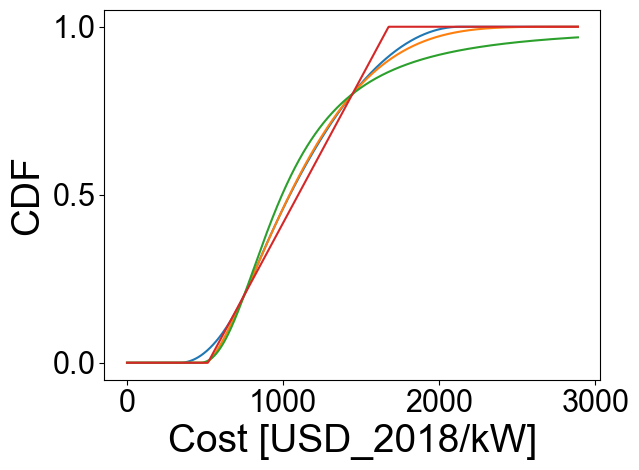

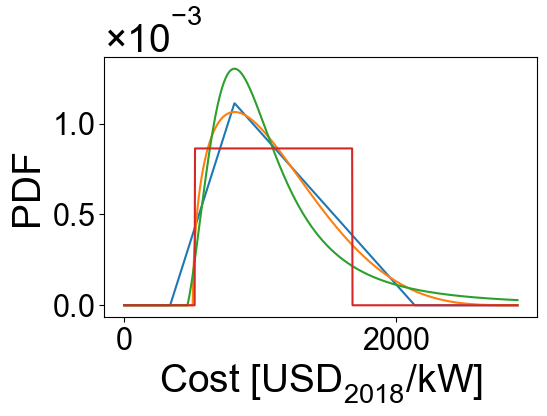

RES_PV


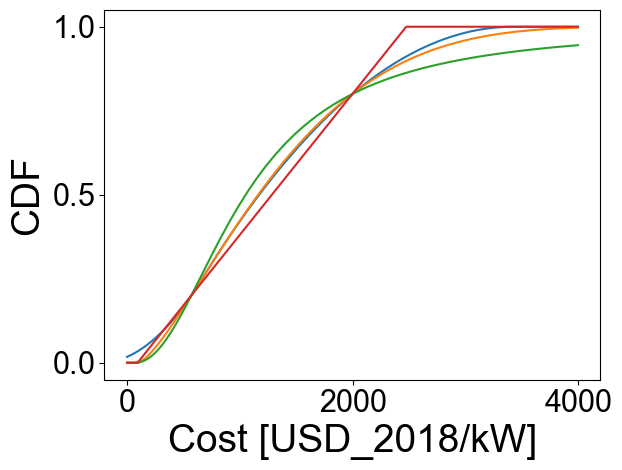

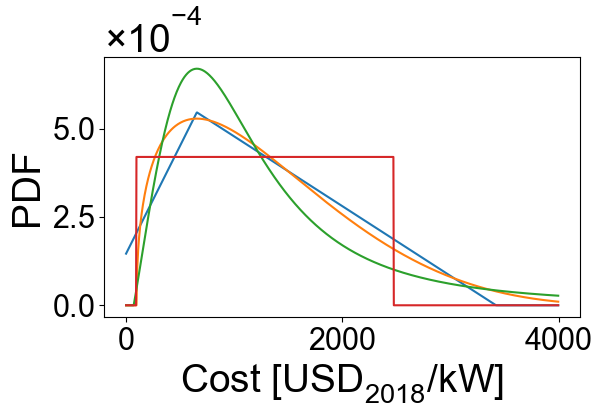

In [89]:
for i in range(data_perc_20_2050.shape[0]):
    data_plot = data_perc_20_2050.iloc[i]
    print(data_plot.tech)
    #print(data_plot)
    x = np.linspace(0, 2.0*data_plot.perc_80, 1000)

    #plt.axvline(float(data_plot.perc_5), linestyle='dashed',label="20th percentile")
    #plt.axvline(float(data_plot.perc_95), linestyle='dotted',label="80th percentile")
    for pdf in pdf_list:
        plot_cdf(func=pdf,x=x,a=float(data_plot[pdf+"_a"]),b=float(data_plot[pdf+"_b"]),c=float(data_plot[pdf+"_c"]))
    plot_cdf_unif(x=x,a=float(data_plot["unif_a"]),b=float(data_plot["unif_b"]))
    #plt.legend(fontsize=15)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
    plt.xlabel("Cost [USD_2018/kW]")
    plt.ylabel("CDF")
    plt.show()

    #plt.axvline(float(data_plot.mu), linestyle='dashed',label="Mode")
    for pdf in pdf_list:
        plot_pdf(func=pdf,x=x,a=float(data_plot[pdf+"_a"]),b=float(data_plot[pdf+"_b"]),c=float(data_plot[pdf+"_c"]))
    plot_pdf_unif(x=x,a=float(data_plot["unif_a"]),b=float(data_plot["unif_b"]))
    #plt.legend(fontsize=15)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
    plt.xlabel("Cost [USD$_{2018}$/kW]")
    plt.ylabel("PDF")
    plt.tight_layout()
    #plt.savefig("pics/pdf_2050_"+data_plot.tech+".pdf", format="pdf")
    plt.show()

# Exporting the results 

In [ ]:
results_perc_5 = data_perc_5.copy()
results_perc_5.drop(["perc_5", "perc_95"], inplace=True, axis=1)
results_perc_20 = data_perc_20.copy()
results_perc_20.drop(["perc_20", "perc_80"], inplace=True, axis=1)
results = pd.concat([results_perc_5, results_perc_20])